# Rap Recommender
<font color='gray'>Capstone Project By Uzodinma Ikwuakor</font>

----

**<font color='steelblue'>Note:</font>** Throughout this report, hover over the <a title="Illustrative purposes only">↩</a>/<a title="Illustrative purposes only">↪</a> symbols to see where the links will redirect you.

## Table of Contents
----
1. [Introduction](#Introduction↩)<a id="refIntroduction"></a><br>
    a. [Wait, jokes and close rhyme?](#Wait)<a id="refWait"></a>
2. [Data](#Data)<a id="refData"></a>
3. [Evaluating Syllables in Reverse](#Reverse)<a id="refReverse"></a>
4. [Generating Lines aka 'Bars'](#Text)<a id="refText"></a><br>
    a. [Hidden Markov Models](#HMM)<a id="refHMM"></a>
5. [Stop Tokens](#Stop)<a id="refStop"></a>
6. [N-grams](#N-grams)<a id="refN-grams"></a>
7. [Summary](#Summary)<a id="refSummary"></a>
8. [Code](#Code)<a id="refCode"></a>
9. [Rap Recommender Examples](#Examples)<a id="refExamples"></a>
10. [Future Work](#Future)<a id="refFuture"></a>
11. [Corpus](#Corpus)<a id="refCorpus"></a>
12. [Footnotes](#Footnotes)<a id="refFootnotes"></a>

## Introduction<a name="Introduction" href="#refIntroduction" title="Back to Table of Contents">↩</a>

----
> #### rap /rap/<br>
_noun_<br>
*- a type of music of African American origin in which rhythmic and usually rhyming speech is chanted to a musical accompaniment*

As a musical art form, hip hop music, where rap is the vocal approach, has a more rhyme-centric lyrical structure than most other forms of music. With rap, the creative usage of rhyme, itself, can often be the primary aim of the musical artist. There are several factors to consider when rapping, aka "rhyming", "spittin'" or "emceein'". Cadence/rhythm, also known as "delivery", as well as rhyme and rhyme scheme (where the rhymes actually occur relative to one another), known as "rhyme flow", are the building blocks of any quality rap song. This version of the rap recommender addresses the rhyming element of "rhyme flow" using a simplistic rhyme scheme known as "end rhyme", or those rhymes that occur between the final words of two lines of poetry. For example...

> _Devil on my shoulder laughing at me while he **cracking jokes**.<br>
> Angel on the other shoulder saying "he just **mad you close**"._<sup><a href="#fn1" id="ref1">1</a></sup>

...you may have noticed that 'cracking jokes' was rhymed with 'mad you close'. Since this rap recommender utilizes a 1-to-1 rhyme word pairing, it could detect that 'jokes' rhymes with 'close'. However, at this time it won't detect when multiple words in one line rhyme with multiple rhymes in another, otherwise know as "multisyllabic" rhyme, or more colloquially among rap enthusiasts, as "multis".

#### Wait, _jokes_ and _close_ rhyme?<a name="Wait" href="#refWait" title="Back to Table of Contents">↩</a> <a name="Patterns" href="#refPatterns" title="Go to Summary">↪</a>
As a matter a fact, they do. It's known as a **half rhyme** where two words have similar vowel sounds and/or number of syllables. I call it a **vowel rhyme** and will continue to do so throughout the remainder of this report. An **exact rhyme** for _jokes_ would be words like _pokes_ or _yolks_ because they share all vowel sounds and consonant sounds except for the leading consonant sound. Another form of rhyme used for this rap recommender is something I called a **strong rhyme** where all vowel sounds match as well as the trailing consonant sound. A rhyme pairing of _rapper_ and _banter_ would fall into this category.

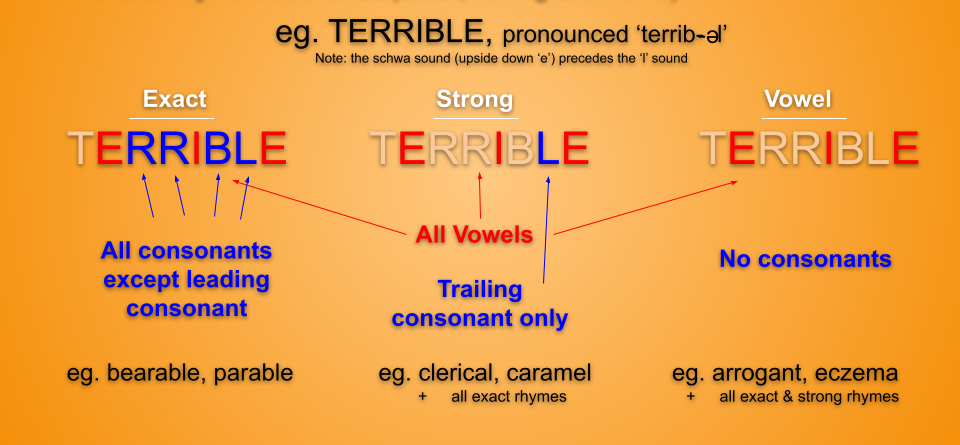

In [1]:
#Image display
from IPython.display import display
from PIL import Image

# Read "Rhyme versions" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot - rhyme dicts.png')
display(img)

## Data<a name="Data" href="#refData" title="Back to Table of Contents">↩</a>

---
**Deconstructing words down to phones:** The data I used to construct my Rapbot is provided by the free, English pronouncing dictionary CMUdict (the Carnegie Mellon pronouncing dictionary).<sup><a href="#fn2" id="ref2">2</a></sup> The dictionary contains over 135 thousand entries with accompanying phone sequences for each word, separated into consonant and vowel sounds. In phonetics, a phone is any distinct speech sound of a word.<sup><a href="#fn3" id="ref3">3</a></sup> The CMUdict breaks words down as follows:

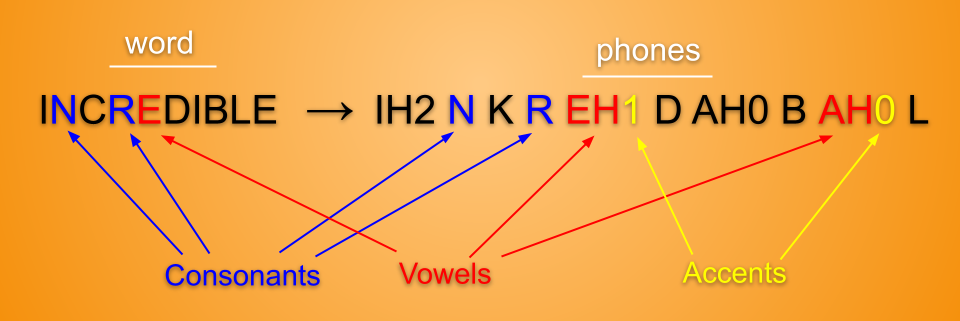

In [2]:
# Read "The Making of a Rapbot" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot -cmudict phones.png')
display(img)

Each word's phone sequence has an accent value attached corresponding to the level of stress put on that vowel. Since most rappers are skilled enough to apply accents in a manner that aids listeners in the audible perception of rhyme, these accent markings could prove themselves to be too restrictive later on when pairing rhyming words. As such, they were removed.

## Evaluating Syllables in Reverse<a name="Reverse" href="#refReverse" title="Back to Table of Contents">↩</a>

---
Although leading consonant sounds might contribute to rhyme pairings like _cable_ and _cabal_, this rap recommender will focus on _exact_, _vowel_ and _strong_ rhyme styles. Therefore, all leading consonant sounds from each word's phones will be removed. From that point, recognizing that the trailing sounds of a word contribute more to its rhyme sound than earlier syllables, ie. _hun-gry_ rhymes more with _an-**gry**_ than it does _**hun**-ter_, syllable tags were added in reverse so that the recommender could recognize in which syllable a consonant or vowel sound occurred. With this in place, rhyme similarity can be determined (see the [cosine_similarity](#Cosine)<a id="refCosine"></a> function in the code section). Since vowels sounds are always in separate syllables, for simplicity's sake, syllables were separated by vowel sounds included with the consonant sounds that followed each vowel sound within that same syllable. That's not how you'll find in done in the dictionary, but for rhyming purposes, it shouldn't matter. You'll notice the underscores followed by a syllable number, eg. '\_1'. These are the syllable tags.

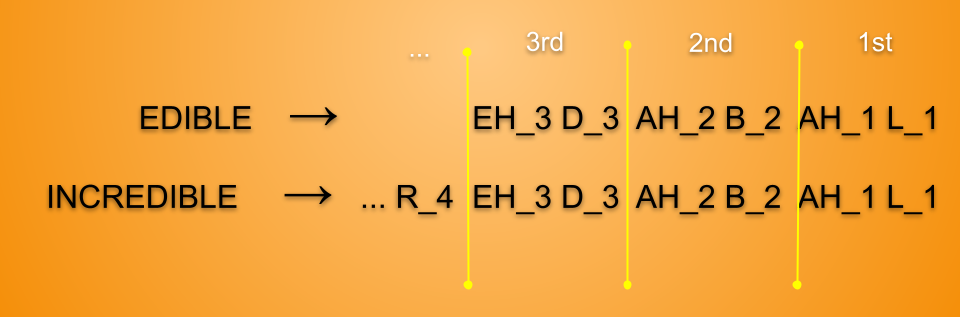

In [3]:
# Read "syllable tag" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot - syllable tags.png')
display(img)

## Generating Lines aka 'Bars'<a name="Text" href="#refText" title="Back to Table of Contents">↩</a>

---
After formatting each word's phones, the next step was generating the actual lines of lyrics. Lines of lyrics in a rap song are often referred to as "bars", and an emphatic utterance of the word, "Bars!", or a #BARS, serves as both a descriptor and a compliment if said bars are worthy of praise.

### Hidden Markov Models<a name="HMM" href="#refHMM" title="Back to Table of Contents">↩</a>
Simply put, a Hidden Markov Model (HMM) is probabilistic model that predicts a sequence of unknown (hidden) variables from a set of observed variables. As it pertains to rap, it's a model that will allow us to predict the next word in a sequence based upon the current word in that sequence and the probability that certain words precede that current word. The following illustration should make it more clear.

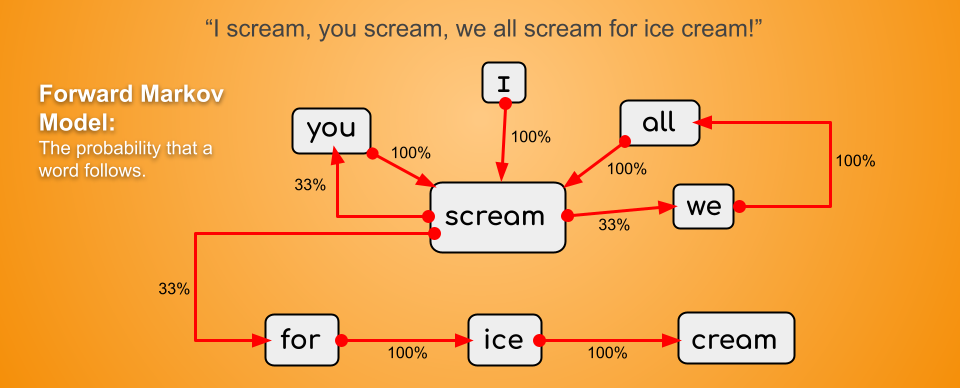

In [4]:

# Read "Forward HMM" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot - fwd HMM.png')
display(img)

Let's imagine that our machine only knew of a single sentence, <font color='red'>"I scream, you scream, we all scream for ice cream."</font> If we fed our recommender the word _scream_ and asked it to predict what word came next, based upon this single sentence, which is the only sentence it knows, it would have no other option but to conclude that 1/3 of the time _scream_ will be followed by _you_, 1/3 of the time it will be followed by _we_ and 1/3 of the time it will be followed by _for_. This means that each time it saw the word _scream_ it would predict those words to follow according to their respective probabilities. It would never, for example, predict that _scream_ might be followed by _ice_ because it has never seen that sequence of words before.

This is _almost_ how our HMM will work. We will familiarize the recommender with some text, known as a **corpus**, and based upon this corpus it will determine the probabilities of certain words following whichever word we feed it. I say _almost_ because when generating bars, we'll be constructing end rhymes, where the last words between two lines rhyme, and then constructing the bar _in reverse_! So instead of predicting which word will follow the word we feed it, we want it to predict which word _precedes_ the word we feed it. 

<sub>**Note:** All punctuation except for apostrophes were removed from the corpus which prevents attempted rhyme pairings with the punctuation. Text will also be lower-cased so that the recommender recognized capitalized words to be the same as their lowercase equivalents.</sub>

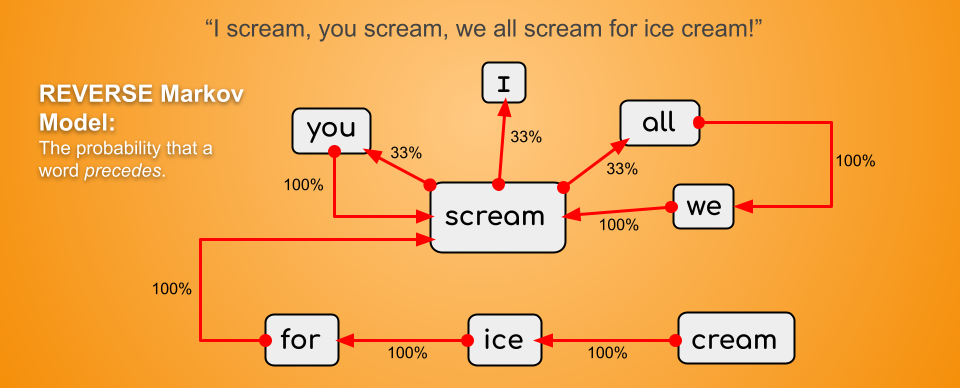

In [5]:
# Read "Forward HMM" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot _rev HMM.png')
display(img)

Now when fed the word _scream_, it will predict _you_, _I_ and _all_ each to precede _scream_ 1/3 of the time.

## Stop Tokens<a name="Stop" href="#refStop" title="Back to Table of Contents">↩</a>

---
In an effort to create naturally sounding lines, two overlapping approaches will be employed. First, we'll insert **stop tokens** within our corpus. Referring back to the lyrics in the [Introduction](#Introduction), the stop tokens will be inserted as follows during the [tokenizing](#Tokenizer)<a id="refTokenizer"></a> process (notice removed punctuation and lowercase text):

> **\</stop>** _devil on my shoulder laughing at me while he cracking jokes **\</stop>**<br>
> **\</stop>** angel on the other shoulder saying he just mad you close **\</stop>**_

With this method, the stop tokens will serve as both beginning-of-sentence and end-of-sentence indicators. When we tell the recommender to stop generating text once it is fed a stop token, that will ensure that our lines begin with the words most likely to appear at the beginning of a line, according to our corpus. Recall that our text is generated in reverse, meaning that it is fed the last word, or end rhyme, first then generates the line in reverse until it either encounters a stop token or has met a predetermined maximum word length, thus completing it's generation process with the first word in the line.

## N-grams<a name="N-grams" href="#refN-grams" title="Back to Table of Contents">↩</a>

An n-gram is a consecutive sequence of _n_ items from a given text. These items could have been our phones, syllables, or letters. For our purposes, n-grams refer to _n_ consecutive words in our corpus. Referring again to the aforementioned lines, "you close" is a 2-gram (a bigram), “mad you close” is a 3-gram (trigram), "just mad you close” is a 4-gram, and so on. The benefit of using n-grams is that they better ensure that parts-of-speech relationships between words are maintained. After all, any number of words may precede a 1-gram like "you" in a corpus, but a bigram like "you close" has a more specific subset of words that have preceded it in the corpus. Generally speaking, the more _n_s in your n-gram, the smaller the subset of preceding words. it's important to note the preceding word probabilities for our HMM change when n-grams change. Notice the following:

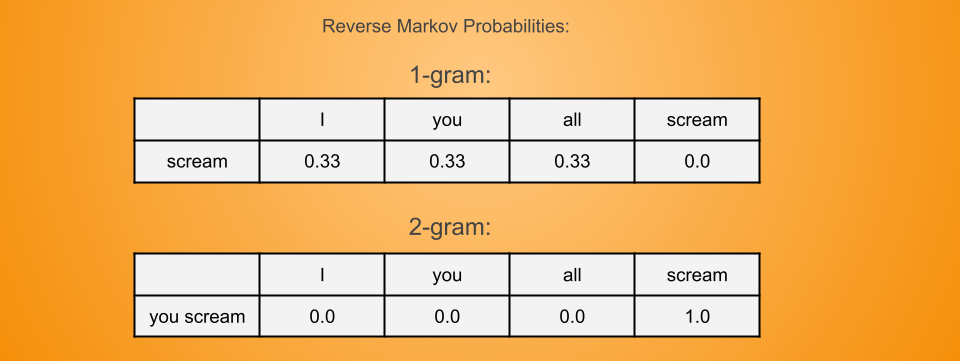

In [6]:
# Read "Forward HMM" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot - N-grams.png')
display(img)

Referring back to the sentence, <font color='red'>"I scream, you scream, we all scream for ice cream."</font> and assuming again that this is the only sentence our recommender knows. The 1-gram "scream" has a 33% chance of being preceded by "I", a 33% chance of being preceded by "you" and a 33% chance of being preceded by "all". However, the bigram "you scream" can only be preceded by the word "scream" given this limited corpus. This is a good thing because it maintains the parts-of-speech relationships that exist in the corpus forbidding a phrase like "I you scream" to be generated.


## Summary<a name="Summary" href="#refSummary" title="Back to Table of Contents">↩</a>

Some of the following was discussed in this report prior to this point while other aspects can be gleamed from the code section below. Use the links, if necessary, to jump between this summary and the relevant sections.

First, each word's phones are transformed by removing leading consonant phones ([see code](#First)<a id="refFirst"></a>), removing the CMUdict accents and then tagging each syllable in reverse ([see code](#Transform)<a id="refTransform"></a>). We then create three rhyme dictionaries ([see code](#Rhyme_dict)<a id="refRhyme_dict"></a>) which reconstruct the phones to contain the vowel and consonant phone sequences according to the **exact**, **strong** or **vowel** rhyme patterns discussed in the [Introduction](#Patterns)<a id="refPatterns"></a>. Using the reverse HMM algorithm and an n-gram designation chosen by the user, text is generated in reverse by (1) taking a user inputted sentence or word into the _Rap Recommender_ ([see code](#Skill)<a id="refSkill"></a>), (2) using one of the three rhyme dictionaries to generate a list of rhyming words ([see code](#Rhymer)<a id="refRhymer"></a>) and (3) picking one of those words at random provided it exists in the [tokenized](#Tokenizer2)<a id="refTokenizer2"></a> corpus then generating text in reverse, stopping either at a stop token (applied during the tokenizing step) or at a user designated max_length output string.

## Code<a name="Code" href="#refCode" title="Back to Table of Contents">↩</a>

In [7]:
import cmudict
import random
import pandas as pd
import re
from tqdm.auto import tqdm # show progress bar

In [8]:
df = pd.DataFrame(cmudict.entries(), columns=['word', 'phones'])
df['exact_rhyme'] = df.phones.apply(list.copy)
df['strong_rhyme'] = df.phones.apply(list.copy)
df['vowel_rhyme'] = df.phones.apply(list.copy)
df.head(2)

word       phones  exact_rhyme strong_rhyme  vowel_rhyme
0   'bout  [B, AW1, T]  [B, AW1, T]  [B, AW1, T]  [B, AW1, T]
1  'cause  [K, AH0, Z]  [K, AH0, Z]  [K, AH0, Z]  [K, AH0, Z]

In [9]:
vowels = ('A', 'E', 'I', 'O', 'U')

### First Consonant Removal<a name="First" href="#refFirst" title="Back to Summary">↩</a>

+ Removes leading consonants (those preceding the first vowel phone) from the phones lists

In [10]:
def first_consonant_removal(phones_lists):
    """ opening consonants removal
    
    >>> first_consonant_removal([['B', 'AW1', 'T'],['K', 'AH0', 'Z']])
    [['AW1', 'T'], ['AH0', 'Z']]
    
    """
    for phone_list in phones_lists:
        for i, phone in enumerate(phone_list):
            i -= i   # in order to always evaluate the first index
            if phone_list[i].startswith(vowels):
                break
            else:
                phone_list.remove(phone_list[i])

    return phones_lists

### Phones Transformation<a name="Transform" href="#refTransform" title="Back to Summary">↩</a>

+ The following three code cells change the phone lists into the exact_rhyme, vowel_rhyme and strong_rhyme phone patterns
+ phones_lists_to_exact_rhyme() calls upon first_consonant_removal()

In [11]:
def phones_lists_to_exact_rhyme(phones_lists=df.exact_rhyme):
    """ first consonant removal, accent removal and syllable tagging

    >>> phones_lists_to_exact_rhyme([['B', 'AW1', 'T'],['K', 'AH0', 'Z']])
    [['AW_1', 'T_1'], ['AH_1', 'Z_1']]
    
    """
    phones_lists = first_consonant_removal(phones_lists) # remove first consonants in place
    
    for phone_list in phones_lists:
        syllable = 1
        for i, phone in enumerate(reversed(phone_list)):
            if phone.startswith(vowels):
                phone_list[-(i+1)] = phone[:-1] + '_' + str(syllable)
                syllable += 1
            else:
                phone_list[-(i+1)] = phone + '_' + str(syllable)
    return phones_lists

In [12]:
phones_lists_to_exact_rhyme(df.exact_rhyme)
df.head()

word          phones       exact_rhyme    strong_rhyme     vowel_rhyme
0    'bout     [B, AW1, T]       [AW_1, T_1]     [B, AW1, T]     [B, AW1, T]
1   'cause     [K, AH0, Z]       [AH_1, Z_1]     [K, AH0, Z]     [K, AH0, Z]
2  'course  [K, AO1, R, S]  [AO_1, R_1, S_1]  [K, AO1, R, S]  [K, AO1, R, S]
3    'cuse  [K, Y, UW1, Z]       [UW_1, Z_1]  [K, Y, UW1, Z]  [K, Y, UW1, Z]
4      'em        [AH0, M]       [AH_1, M_1]        [AH0, M]        [AH0, M]

In [13]:
def phones_lists_to_vowel_rhyme(phones_lists=df.vowel_rhyme):
    """ consonant removal, accent removal and syllable tagging

    >>> phones_lists_to_vowel_rhyme([['B', 'AW1', 'T'],['K', 'AH0', 'Z']])
    [['AW_1'], ['AH_1']]
    
    """
    for phone_list in phones_lists:
        syllable = 1
        remove_counter = 0
        for i, phone in enumerate(reversed(phone_list)):
            if phone_list[-(i+1) + remove_counter].startswith(vowels):
                phone_list[-(i+1) + remove_counter] = phone[:-1] + '_' + str(syllable)
                syllable += 1
            else:
                phone_list.remove(phone_list[-(i+1) + remove_counter])
                remove_counter += 1
    return phones_lists

In [14]:
phones_lists_to_vowel_rhyme(df.vowel_rhyme)
df.head()

word          phones       exact_rhyme    strong_rhyme vowel_rhyme
0    'bout     [B, AW1, T]       [AW_1, T_1]     [B, AW1, T]      [AW_1]
1   'cause     [K, AH0, Z]       [AH_1, Z_1]     [K, AH0, Z]      [AH_1]
2  'course  [K, AO1, R, S]  [AO_1, R_1, S_1]  [K, AO1, R, S]      [AO_1]
3    'cuse  [K, Y, UW1, Z]       [UW_1, Z_1]  [K, Y, UW1, Z]      [UW_1]
4      'em        [AH0, M]       [AH_1, M_1]        [AH0, M]      [AH_1]

In [15]:
def phones_lists_to_strong_rhyme(phones_lists=df.strong_rhyme):
    """ consonant removal (save for last syllable consonants), accent removal and syllable tagging

    >>> phones_lists_to_strong_rhyme([['Z', 'UW1', 'G', 'AA0', 'N', 'AA0', 'V']])
    [['UW_3', 'AA_2', 'AA_1', 'V_1']]
    
    """
    for phone_list in phones_lists:
        syllable = 1
        remove_counter = 0
        for i, phone in enumerate(reversed(phone_list)):
            if phone_list[-(i+1) + remove_counter].startswith(vowels):
                phone_list[-(i+1) + remove_counter] = phone[:-1] + '_' + str(syllable)
                syllable += 1
            elif not phone_list[-(i+1) + remove_counter].startswith(vowels) and syllable < 2:
                phone_list[-(i+1)] = phone + '_' + str(syllable)
            else:
                phone_list.remove(phone_list[-(i+1) + remove_counter])
                remove_counter += 1
    return phones_lists

In [16]:
phones_lists_to_strong_rhyme(df.strong_rhyme)
df.tail()

word                             phones  \
135149    zyuganov     [Z, Y, UW1, G, AA0, N, AA0, V]   
135150    zyuganov        [Z, UW1, G, AA0, N, AA0, V]   
135151  zyuganov's  [Z, Y, UW1, G, AA0, N, AA0, V, Z]   
135152  zyuganov's     [Z, UW1, G, AA0, N, AA0, V, Z]   
135153     zywicki           [Z, IH0, W, IH1, K, IY0]   

                                   exact_rhyme                  strong_rhyme  \
135149       [UW_3, G_3, AA_2, N_2, AA_1, V_1]       [UW_3, AA_2, AA_1, V_1]   
135150       [UW_3, G_3, AA_2, N_2, AA_1, V_1]       [UW_3, AA_2, AA_1, V_1]   
135151  [UW_3, G_3, AA_2, N_2, AA_1, V_1, Z_1]  [UW_3, AA_2, AA_1, V_1, Z_1]   
135152  [UW_3, G_3, AA_2, N_2, AA_1, V_1, Z_1]  [UW_3, AA_2, AA_1, V_1, Z_1]   
135153            [IH_3, W_3, IH_2, K_2, IY_1]            [IH_3, IH_2, IY_1]   

               vowel_rhyme  
135149  [UW_3, AA_2, AA_1]  
135150  [UW_3, AA_2, AA_1]  
135151  [UW_3, AA_2, AA_1]  
135152  [UW_3, AA_2, AA_1]  
135153  [IH_3, IH_2, IY_1]

### Rhyme dictionaries<a name="Rhyme_dict" href="#refRhyme_dict" title="Back to Summary">↩</a>

+ rhyme dictionaries created in accordance to the phone **vowel**, **strong**, and **exact** rhyme patterns

In [17]:
def vowel_dictionary(phones_lists=df.vowel_rhyme):
    """ Returns a dictionary with vowel_rhyme phones as the keys and associated words as the values
    """
    vowel_dict = {' '.join(k):[] for k in phones_lists}
    for idx, vows in enumerate(tqdm(phones_lists,  desc="Constructing 'vowel' dictiionary", leave=True)):
        vowel_dict[' '.join(vows)].append(df.word[idx])
        
    return vowel_dict

In [18]:
def strong_dictionary(phones_lists=df.strong_rhyme):
    """ Returns a dictionary with strong_rhyme phones as the keys and associated words as the values
    """
    strong_dict = {' '.join(k):[] for k in phones_lists}
    for idx, vows in enumerate(tqdm(phones_lists, desc="Constructing 'strong' dictiionary", leave=True)):
        strong_dict[' '.join(vows)].append(df.word[idx])
        
    return strong_dict

In [19]:
def exact_dictionary(phones_lists=df.exact_rhyme):
    """ Returns a dictionary with exact_rhyme phones as the keys and associated words as the values
    """
    exact_dict = {' '.join(k):[] for k in phones_lists}
    for idx, vows in enumerate(tqdm(phones_lists, desc="Constructing 'exact' dictiionary", leave=True)):
        exact_dict[' '.join(vows)].append(df.word[idx])
        
    return exact_dict

In [20]:
exact_dict = exact_dictionary(df.exact_rhyme)

Constructing 'exact' dictiionary:   0%|          | 0/135154 [00:00<?, ?it/s]

In [21]:
strong_dict = strong_dictionary(df.strong_rhyme)

Constructing 'strong' dictiionary:   0%|          | 0/135154 [00:00<?, ?it/s]

In [22]:
vowel_dict = vowel_dictionary(df.vowel_rhyme)

Constructing 'vowel' dictiionary:   0%|          | 0/135154 [00:00<?, ?it/s]

In [23]:
# Finding the exact_rhyme phone sequence for 'terrible'
exact_phones = df.loc[df.word.eq('terrible').idxmax(), 'exact_rhyme']
exact_phones

['EH_3', 'R_3', 'AH_2', 'B_2', 'AH_1', 'L_1']

In [24]:
# Exact rhymes for 'terrible'
exact_dict[' '.join(exact_phones)]

['bearable', 'marable', 'parable', 'terrible', 'wearable']

In [25]:
# Finding the strong_rhyme phone sequence for 'terrible'
strong_phones = df.loc[df.word.eq('terrible').idxmax(), 'strong_rhyme']
strong_phones

['EH_3', 'AH_2', 'AH_1', 'L_1']

In [26]:
# Strong rhymes for 'terrible'
print(strong_dict[' '.join(strong_phones)])

['arundel', 'bearable', 'caramel', 'cerebral', 'chemical', 'clerical', 'credible', 'decimal', 'deshotel', 'edible', 'epochal', 'equable', 'festival', 'flexible', 'genital', 'legible', 'marable', 'marital', 'medical', 'oedipal', 'parable', 'pedestal', 'plentiful', 'plentiful', 'preferable', 'rentable', 'retinal', 'sectional', 'seminal', 'sensible', 'sensual', 'sentinel', 'skeletal', 'skeptical', 'spectacle', 'spendable', 'tenable', 'tentacle', 'terrible', 'vegetable', 'vegetal', 'venable', 'wearable']


In [27]:
# Finding the vowel_rhyme phone sequence for 'terrible'
vowel_phones = df.loc[df.word.eq('terrible').idxmax(), 'vowel_rhyme']
vowel_phones

['EH_3', 'AH_2', 'AH_1']

In [28]:
# Vowel rhymes for 'terrible' 
print(vowel_dict[' '.join(vowel_phones)])

['aaronson', "aaronson's", 'adelman', 'aeschelus', 'aronson', 'arrogance', 'arrogant', 'arundel', 'baronet', 'baronets', 'barragan', 'bearable', 'bedouin', 'bedouins', 'belkacem', 'benelux', 'benetton', "benetton's", 'benezra', 'benjamin', "benjamin's", 'bezanson', 'blessedness', 'caramel', 'carelessness', 'carolus', 'carriages', 'carrollton', 'celebate', 'celebrant', 'celebrants', 'celebre', 'cerebral', 'chemical', "chemicals'", 'clarendon', 'clemensen', 'clendenen', 'clerical', 'credible', 'credited', 'credulous', 'daedalus', 'decadence', 'decadent', 'decadents', 'decibels', 'decimal', 'decimals', 'deficit', "deficit's", 'definite', 'dehaven', 'delahunt', 'delashmutt', 'delavan', 'delegate', 'delegates', 'delicate', 'denizen', 'denizens', 'derusha', 'deshotel', 'deshotels', 'desolate', 'desolate', 'detriment', 'detritus', 'devona', 'eblen', 'eczema', 'eddleman', 'edelen', 'edelman', "edelman's", 'edelmann', 'edenton', 'edible', 'edibles', 'edifice', 'edited', 'edleman', 'edmondson', 

### Rhyme Search<a name="Rhymer" href="#refRhymer" title="Back to Summary">↩</a> <a name="Rhymer2" href="#refRhymer2" title="Go to Rap Recommender Skill">↪</a>

+ rhymer() calls on rhyme_dict() to access the specified rhyme dictionary, then it selects rhyme pairings according to the phones sequence (keys are the phones sequences, values are the corresponding rhyme pairing candidates).

In [29]:
def rhyme_dict(dict_type='strong'):
    if dict_type=='exact':
        dictionary = exact_dictionary()
    elif dict_type=='strong':
        dictionary = strong_dictionary()
    elif dict_type=='vowel':
        dictionary = vowel_dictionary()
    else:
        print("Invalid dictionary type; choose between 'exact', strong' or 'vowel' dict_type")
        return
    return dictionary

In [30]:
def rhymer(source, dict_type='strong'):
    dictionary = rhyme_dict(dict_type)
    if type(dictionary) is not dict:
        return
    phones_type = f'{dict_type}_rhyme'
    phones = ' '.join(df.loc[df.index[df.word==source][0], phones_type])
    candidates = dictionary[phones]
    candidates.remove(source)
    
    return candidates

In [31]:
candidates = rhymer('friend', 'exact')
print(candidates)

Constructing 'exact' dictiionary:   0%|          | 0/135154 [00:00<?, ?it/s]

['bend', 'blend', 'end', 'ende', 'fend', 'lend', 'mend', 'mende', 'penned', 'rende', 'send', 'spend', 'tend', 'trend', 'wend', 'wende']


### Tokenizer<a name="Tokenizer" href="#refTokenizer" title="Back to Stop Tokens">↩</a> <a name="Tokenizer2" href="#refTokenizer2" title="Back to Summary">↩</a> <a name="Tokenizer3" href="#refTokenizer3" title="Go to Rap Recommender Skill">↪</a>

+ Removes all punctuation except apostrophes from the corpus or input string
+ Inserts stop tokens

In [32]:
def tokenizer(corpus):
    corpus = re.sub(r"[^\w\d'\s]+", '', corpus) # Removing punctuation except apostrophes
    corpus = corpus.lower()
    corpus = corpus.replace('\t',' ')
    corpus = corpus.replace('\n',' </stop> ') # Stop tokens
    corpus = corpus.strip().split()
    
    return corpus

In [33]:
#Get the MF DOOM lyrics corpus
myfile = open("/home/uzi/code/public_code/qary/src/qary/etl/rap_corpus.txt")
corpus = myfile.read()
words = tokenizer(corpus)
myfile.close()

In [34]:
words = tokenizer(corpus)

In [35]:
words[:10]

['mic', 'check', '</stop>', 'when', 'i', 'was', 'led', 'to', 'you', '</stop>']

In [36]:
len(words)

3408

### Stochastic Chain<sup><a href="#fn5" id="ref5">5</a></sup> <a name="Stochastic" href="#refStochastic" title="Go to Rap Recommender Skill">↪</a>
+ stochastic_chain() checks to make sure the seed (input string/input n-gram) matches the seed_length
+ stochastic_chain() takes a max and min length argument to ensure adequate length lines of lyrics
+ stochastic_chain() calls word_before_n_gram() to find the word before the input n-gram (and subsequent rolling n-grams)
    + word_before_n_gram() calls prior_word_matrix() to generate an n-grams matrix and an n_grams dictionary of keys from the set of words in the corpus for the current n-gram
    + from the n-grams matrix and the n-grams dictionary of keys, word_before_n_gram() generates a probability vector for the current n-gram then selects a preceding word according to the probabilities therein
        + the columns of the probability vector represent prior words, the row represents the current n-gram


In [37]:
# scipy’s dok_matrix, or "Dictionary of Keys" (sparse) matrix
from scipy.sparse import dok_matrix

def prior_word_matrix(words, n=1):
    word_set = list(set(words))
    word_dok = {word: i for i, word in enumerate(word_set)}
    if n > 1:
        n_grams = [ ' '.join(words[i:i+n]) for i, _ in enumerate(words[:-n+1]) ]
    else:
        n_grams = [ ' '.join(words[i:i+n]) for i, _ in enumerate(words) ]

    sets_count = len(list(set(n_grams)))
    prior_word_matrix = dok_matrix((sets_count, len(word_set)))

    n_grams_set = list(set(n_grams))
    n_grams_dok = {word: i for i, word in enumerate(n_grams_set)}

    for i, word in enumerate(n_grams[-1:n:-1]):
        n_grams_idx = n_grams_dok[word]
        prior_word_idx = word_dok[list(reversed(words))[i+n]]
        prior_word_matrix[n_grams_idx, prior_word_idx] +=1
        
    return prior_word_matrix, n_grams_dok, word_set

In [38]:
# Sampling matrix

def word_before_n_gram(word_sequence, n=1):
    p_matrix, n_grams_dok, word_set = prior_word_matrix(words, n)
    index = n_grams_dok[word_sequence]
    prior_word_vector = p_matrix[index]
    probability = prior_word_vector/prior_word_vector.sum()  # [1, 0, 0, 2, 1] --> [0.25, 0, 0, 0.5, 0.25]
    
    return random.choices(word_set, probability.toarray()[0]) # selects column associated word according to 
                                                                    # probability vector, eg. [0.25, 0, 0, 0.5, 0.25]
    
def stochastic_chain(seed, min_length=6, max_length=12, seed_length=1):
    current_words = seed.split(' ')
    if len(current_words) != seed_length:
        raise ValueError(f'wrong number of words, expected {seed_length}')
    sentence = seed

    for _ in range(max_length - len(current_words)):
        next_word = word_before_n_gram(' '.join(current_words), seed_length)
        if next_word[0] == '</stop>' and len(sentence.split()) >= min_length:
            break
        else:
            sentence = next_word[0] + ' ' + sentence
            current_words = current_words[::-1] # reverse the word order
            current_words = current_words[1:]+next_word
            current_words = current_words[::-1] # reverse the word order again to put new word in front
    return sentence.replace('</stop>', '')

In [39]:
# example use    
stochastic_chain("all time", seed_length=2)

'that ass in half like obiwan kenobi  greatest of all time'

## The Rap Recommender Skill<a name="Skill" href="#refSkill" title="Back to Summary">↩</a>

+ Takes user input and returns a rhyming line
+ Calls on tokenizer() to remove punctuation and lowercase the input string ([see code](#Tokenizer3)<a id="refTokenizer3"></a>)
+ Calls upon rhymer() to create a list of rhyming words that rhyme with the final word in the input string ([see code](#Rhymer2)<a id="refRhymer2"></a>)
+ Shuffles the rhyming word list and then iterates through it until it finds a word that is in the corpus which it will then use to generate a lines of lyrics
+ Calls on stochastic_chain() twice to both create the n-gram and then use that n-gram to create the rhyming line ([see code](#Stochastic)<a id="refStochastic"></a>)
+ Returns the rhyming line

In [40]:
#from qary.etl.rap_funcs import tokenizer, rhymer
from qary.skills.rap import Skill
from qary.etl import rap_funcs

In [41]:
class Skill:
    r"""Returning a rhyming sentence"""
    def __init__(self, statement, n_gram=1, clean=True, context=None):
        self.statement = statement
        self.n_gram = n_gram
        self.clean = clean

    def reply(self):
        r"""Returns a line in which the final word rhymes with the final word of the input string

        Examples:
            #TODO
        """
     
        # Removing any punctuation except apostrophes, returns list
        statement = rap_funcs.tokenizer(self.statement)
        rhyming_words = rap_funcs.rhymer(statement[-1]) # list of words that rhyme with the last word in 
                                                          # input statement
        random.shuffle(rhyming_words)
        response = ''
        for word in rhyming_words:
            if word in rap_funcs.words:
                seed = rap_funcs.stochastic_chain(word, clean=self.clean, min_length=self.n_gram, max_length=self.n_gram)
                response = rap_funcs.stochastic_chain(seed, clean=self.clean, seed_length=self.n_gram)
                break
        if response == '':
            print("No sentence able to be generated")
            return

        return response

## Rap Recommender Examples<a name="Examples" href="#refExamples" title="Back to Table of Contents">↩</a>

In [73]:
Skill("I'm feeling happy!", n_gram=2, clean=True).reply()

Constructing 'strong' Dictionary:   0%|          | 0/135154 [00:00<?, ?it/s]

'within the prophecies hold the lie  he nasty'

In [77]:
Skill("That's what I hate!", n_gram=2, clean=True).reply()

Constructing 'strong' Dictionary:   0%|          | 0/135154 [00:00<?, ?it/s]

'up in the mosh pit  gosh it feels great'

## Future Work<a name="Future" href="#refFuture" title="Back to Table of Contents">↩</a>

#### [cosine_similarity():](#Cosine2)<a id="refCosine2"></a> <font color='green'>functional</font>

Future work would include modularizing the [bag of phones](#Bag)<a id="refBag"></a> cell below, having cosine_similarity() call upon it, then incorporating it into the Rap Recommender Skill (see **rhyme_finder()** below)

#### [rhyme_finder():](#RF)<a id="refRF"></a> <font color='green'>functional</font> <font color='green'>functional</font>

+ rhyme_finder() currently works as intended, but works to slowly for practical use. Could one day be used to allow users to pick a scoring threshold above which a rhyme candidates will chosen at random. I imagine this will be most useful for vowel rhymes as these often tend not to rhyme at all. Then again, if variety is the aim, this function may ultimately have no useful purpose at all.
+ rhyme_finder() calls cosine_similarity() to create similarity scores
+ Future work would include incorporating it into the Rap Recommender Skill as a user option

#### Clean raps:  <font color='red'> non-functional</font>

I've attempted to add a curse word filter into the Rap Recommender Skill. The option exists, but is not currently operating correctly. Future work would involve correcting this.

#### Slang and misspellings:  <font color='red'> non-functional</font>

Future work would include devising a way for the rap recommender to generate phones for words that are not in the CMUdict, such as slang, many words ending in '-ness' and uncommon proper names (brand names, rap monikers, etc.)

#### Multisyllabic rap/'Multis' recognition:  <font color='orange'> partially functional</font>

[syllablizer()](#Syllables)<a id="refSyllables"></a> currently extracts relevant phones for a user defined number of words and then combines them into a single phone sequence. However, it doesn't re-tag the syllables. The goal is to incorporate syllablizer() to:
1. Generate multisyllabic phone sequence equal to a user defined number of _syllables_, not words, from an input statement
    a. The trick will be how to handle the syllable tags, which will not match phone sequences that came from a single word
2. Parse a rhyme dictionaries (perhaps user defined, or all of them) for phone sequences that can be combined to match the multisyllabic phone sequence.
3. Extract words relative to each phone sequence and HOPEFULLY maintain appropriate parts-of-speech combinations in the resulting n-gram
4. Use this n-gram as a seed in the Rap Recommender Skill

### Bag of Phones<a name="Bag" href="#refBag" title="Back to Future Work">↩</a>
+ Vectorize each word according to its syllable-tagged phones sequence (see image below)

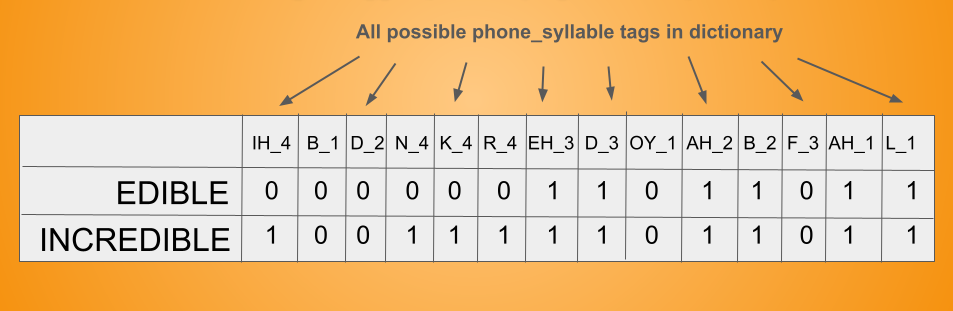

In [44]:
# Read "Bag of phones" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot - bag_of_phones.png')
display(img)

In [46]:
# bag of phones
for idx, phone_list in enumerate(tqdm(df.exact_rhyme)):
    for phone in phone_list:
        if phone in df.columns:
            df.loc[idx, phone] += 1
        else:
            df[phone] = 0
            df.loc[idx, phone] += 1
df.head(2)

  0%|          | 0/135154 [00:00<?, ?it/s]

word       phones  exact_rhyme strong_rhyme vowel_rhyme  AW_1  T_1  AH_1  \
0   'bout  [B, AW1, T]  [AW_1, T_1]  [AW_1, T_1]      [AW_1]     1    1     0   
1  'cause  [K, AH0, Z]  [AH_1, Z_1]  [AH_1, Z_1]      [AH_1]     0    0     1   

   Z_1  AO_1  ...  UH_7  AA_8  EY_7  V_8  CH_7  UW_8  UW_7  OW_8  JH_7  ZH_5  
0    0     0  ...     0     0     0    0     0     0     0     0     0     0  
1    1     0  ...     0     0     0    0     0     0     0     0     0     0  

[2 rows x 299 columns]

### Word Search<a name="WordSearch" href="#refWordSearch" title="Go to cosine_similarity()">↪</a>

+ Finds word vectors or creates word vectors from closed-formed compound words like “grandmother” --> "grand" + "mother" or open-formed compound words, like "rubber band" spelled in a closed-form fashion, like "rubberband" --> "rubber" + "band"
    + Open-formed compound words must be entered as closed-formed compound words
    + Hyphenated compound words in the corpus, like "long-term" should have already been converted to open-formed compound words ("long term") via the tokenizing process

In [48]:
def word_search(source, target):
    for idx, word in enumerate([source, target]):
        if word in list(df.word) and idx == 0:
            source_vector = list(df.iloc[df.index[df.word==source][0], 5:]) # series-to-vector of first source word occurrence
        elif word in list(df.word) and idx == 1:
            target_vector = list(df.iloc[df.index[df.word==target][0], 5:]) # series-to-vector of first target word occurrence
        else:
            for i in range(len(word)):
                if word[:i+1] in list(df.word) and word[i+1:] in list(df.word):
                    left_word = df.loc[df.index[df.word==word[:i+1]][0], 'exact_rhyme']
                    right_word = [df.loc[df.index[df.word==word[i+1:]][0], 'phones'][0] + '_x' ] + df.loc[df.index[df.word==word[i+1:]][0], 'exact_rhyme']
                    conjunction = left_word + right_word
                    # Redoing the syllables for the conjunction
                    syllable = 1
                    for i, phone in enumerate(reversed(conjunction)):
                        if phone.startswith(vowels):
                            conjunction[-(i+1)] = phone[:-1] + str(syllable)
                            syllable += 1
                        else:
                            conjunction[-(i+1)] = phone[:-1] + str(syllable)
                    break
            vector = []
            for column in df.columns[5:]:
                if column in conjunction:
                    vector.append(1)
                else:
                    vector.append(0)
            if idx == 0:
                source_vector = vector
            else:
                target_vector = vector
    return source_vector, target_vector

### Cosine Similarity<sup><a href="#fn4" id="ref4">4</a></sup> <a name="Cosine" href="#refCosine" title="Back to Evaluating Syllables...">↩</a> <a name="Cosine2" href="#refCosine2" title="Back to Future Work">↩</a>
The cosine of the angle between two word vectors
+ Calls upon [word_search()](#WordSearch)<a id="refWordSearch"></a> to find word vectors or create word vectors from closed-formed compound words, or open-formed compound words _composed_ in closed-form, like "rubberband" --> 'rubber' + 'band'

In [49]:
import math

def cosine_similarity(source, target):
    source_vector, target_vector = word_search(source, target)
    
    dot_prod = 0
    for i, v in enumerate(source_vector):
        dot_prod += v * target_vector[i]
        
        mag_1 = math.sqrt(sum([x**2 for x in source_vector]))
        mag_2 = math.sqrt(sum([x**2 for x in target_vector]))
        
        score = dot_prod / (mag_1 * mag_2)
    return  round(score, 2)

In [50]:
# scoring compound word 'rubberband'
cosine_similarity("understand", "rubberband")

0.63

In [51]:
cosine_similarity("water", "daughter")

1.0

In [52]:
cosine_similarity("dog", "cat")

0.0

### Rhymefinder <a name="RF" href="#refRF" title="Back to Future Work">↩</a>

+ Creates a sorted list of tuples, (rhyming_word, rhyme_score), of vowel_rhyme candidates using an exact_rhyme, cosine similarity threshold score, relative to an input/source word.
    + Scoring is optional, in which case it would just return a list of candidates regardless of threshold
    + 'threshold=' only applied when scores=True

In [55]:
def rhyme_finder(source, scores=False, threshold=0.5):
    """
    Creates a sorted list of tuples, (rhyming_word, rhyme_score), of vowel_rhyme candidates using an exact_rhyme,
    cosine similarity threshold score

    Parameters
    ----------
    source: str, word used to generate rhyme candidates
    scores: bool, True => threshold applied with accompanied score, False => no threshold applied, default False
    threshold: float, minimum score needed to be included in the list (only applied for scores=True), default 0.5
    """
    vows = ' '.join(df[df.word==source].vowel_rhyme.values[0]) # vowel rhyme phones sequence
    candidates = vowel_dict[vows]
    if scores==True:
        finalists = []
        for target in tqdm(candidates, desc="Scoring rhyme candidates", leave=False):
            score = cosine_similarity(source, target)
            if score >= threshold:
                finalists.append((target, score)) # generate tuple, (rhyme_candidate, similarity score)
        finalists.sort(reverse = True, key = lambda x: x[1])
        finalists.remove((source, 1.0))
        candidates = finalists
        return candidates
    else:
        return candidates

In [56]:
print(rhyme_finder('water', True, 0.6))

Scoring rhyme candidates:   0%|          | 0/519 [00:00<?, ?it/s]

[('boughter', 1.0), ('daughter', 1.0), ('lawter', 1.0), ('sautter', 1.0), ('slaughter', 1.0), ('straughter', 1.0), ('vawter', 1.0), ('altar', 0.87), ('alter', 0.87), ('auster', 0.87), ('balter', 0.87), ('corter', 0.87), ('coster', 0.87), ('courter', 0.87), ("daughter's", 0.87), ('daughters', 0.87), ("daughters'", 0.87), ('falter', 0.87), ('gloucester', 0.87), ('gorter', 0.87), ('halter', 0.87), ('horter', 0.87), ('kalter', 0.87), ('kloster', 0.87), ('koester', 0.87), ('malter', 0.87), ('mautner', 0.87), ('mortar', 0.87), ('morter', 0.87), ('porter', 0.87), ('psalter', 0.87), ('quarter', 0.87), ('salter', 0.87), ('saulter', 0.87), ('saunter', 0.87), ('shorter', 0.87), ('slaughtered', 0.87), ('slaughters', 0.87), ('snorter', 0.87), ('sorter', 0.87), ('sortor', 0.87), ('stalter', 0.87), ('wachter', 0.87), ('walter', 0.87), ("water's", 0.87), ('watered', 0.87), ('waters', 0.87), ('baugher', 0.82), ('bawer', 0.82), ('brawer', 0.82), ('flaugher', 0.82), ('mawr', 0.82), ('plaugher', 0.82), ('

### Syllablizer<a name="Syllables" href="#refSyllables" title="Back to Future Work">↩</a>

In [57]:
def syllablizer(source, words=1):
    text = source.split()
    i = 1
    syllables = ''
    while i <= words:
        vowels = ' '.join(df[df.word==text[-i]].vowel_rhyme.values[0])
        syllables = f'{vowels} ' + syllables
        i += 1
    return syllables

def rhymer(syllables):
    '''lst = []
    syllable_length = len(syllables.split())
    if sum(lst) <= syllable_length:
        lst.append(random.sample(range(1,syllable_length), 1)[0])
        print(sum(lst))
        syllable_length -= sum(lst) + 1
    print(lst)'''
    syllables = syllables.split()
    rhyme_list = vow_dict[' '.join(syllables[-2:])]
    rhyme_list2 = vow_dict[' '.join(syllables[-3:-2])]
    try:
        print(random.sample(rhyme_list2, 10), '\n', random.sample(rhyme_list, 10))
    except:
        print(' '.join(syllables[-2:]),'None')
        

In [58]:
syllablizer('we are friendly', 2)

'AA_1 EH_2 IY_1 '

## Corpus<a name="Corpus" href="#refCorpus" title="Back to Table of Contents">↩</a>

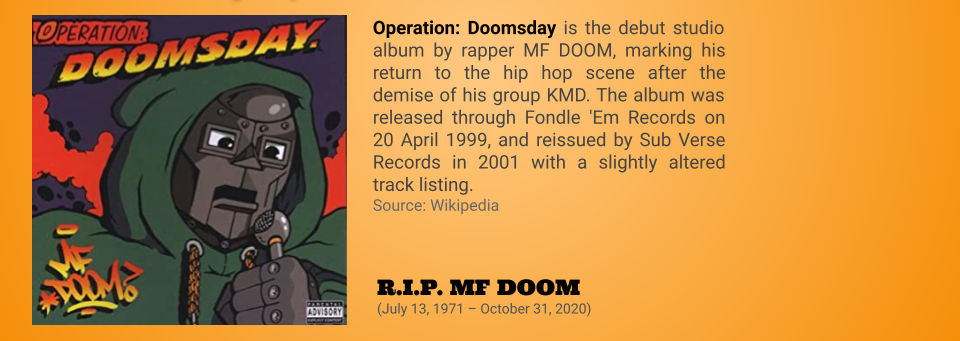

In [78]:
# Read "Bag of phones" image
img = Image.open('/home/uzi/Downloads/The Making of a Rapbot - MF_DOOM_corpus.png')
display(img)

## Footnotes<a name="Footnotes" href="#refFootnotes" title="Back to Table of Contents">↩</a>

<sup id="fn1">1. GQ. "Last Breath". Check out the <a href="https://www.youtube.com/watch?v=jCImAzVVD3E">audio</a> here (Warning: Explicit Content)<a href="#ref1" title="Jump back to footnote 1 in the text.">↩</a></sup>

<sup id="fn2">2. Copyright (C) 1993-2015 Carnegie Mellon University. All rights reserved.<a href="#ref2" title="Jump back to footnote 2 in the text.">↩</a></sup>

<sup id="fn3">3. Phone (phonetics), <a href="https://en.wikipedia.org/wiki/Phone_(phonetics)#:~:text=In%20phonetics%20and%20linguistics%2C%20a,change%20one%20word%20to%20another.">Wikipedia </a><a href="#ref3" title="Jump back to footnote 3 in the text.">↩</a></sup>

<sup id="fn4">4. Cosine similarity <a href="https://en.wikipedia.org/wiki/Cosine_similarity">Wikipedia </a><a href="#ref4" title="Jump back to footnote 4 in the code section.">↩</a></sup>

<sup id="fn5">5. Stochastic process <a href="https://en.wikipedia.org/wiki/Stochastic_process">Wikipedia </a><a href="#ref5" title="Jump back to footnote 5 in the code section.">↩</a></sup>